# Demos: Lecture 19

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

## Demo 1: depolarizing noise

In [2]:
def prepare_state():
    qml.RY(2 * np.pi/3, wires=0)


In [3]:
dev = qml.device("default.mixed", wires=1)

In [4]:
@qml.qnode(dev)
def cicuit():
    prepare_state()
    qml.DepolarizingChannel(0.02, wires=0)
    # return qml.state()
    return qml.probs(wires=0)

In [5]:
cicuit()

array([0.25666667, 0.74333333])

## Demo 2: simulated noisy VQE

In [ ]:
# python -m pip install pennylane-qiskit

In [6]:
coeffs = [28.657, 0.218, -6.125, -9.625, -13.125, -2.143, -3.913, -5.671, -2.143, -3.913, -5.671]

ops = [
    qml.Identity(0), 
    qml.PauliZ(0),
    qml.PauliZ(1),
    qml.PauliZ(2),
    qml.PauliZ(3),
    qml.PauliX(0) @ qml.PauliX(1),
    qml.PauliX(1) @ qml.PauliX(2),
    qml.PauliX(2) @ qml.PauliX(3),
    qml.PauliY(0) @ qml.PauliY(1),
    qml.PauliY(1) @ qml.PauliY(2),
    qml.PauliY(2) @ qml.PauliY(3)
]

H = qml.Hamiltonian(coeffs, ops, grouping_type="qwc")

In [7]:
def ansatz(params):
    qml.PauliX(wires=0)
    for wire in range(3):
        qml.CRY(params[wire], wires=[wire, wire+1])
        qml.CNOT(wires=[wire+1, wire])
    return qml.expval(H)

In [8]:
dev = qml.device("default.qubit", wires=4, shots=10000)

In [9]:
from qiskit.test.mock import FakeManila
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.transpiler import CouplingMap

# Set up noisy fake Manila device
processor_name = "Manila"
device = QasmSimulator.from_backend(FakeManila())
noise_model = NoiseModel.from_backend(device, readout_error=False)
dev_noisy = qml.device(
    "qiskit.aer", backend="qasm_simulator", wires=5, shots=10000, noise_model=noise_model
)

coupling_map = CouplingMap([(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3)])
initial_layout = [0, 1, 2, 3, 4]

dev_noisy.set_transpile_args(
    **{"optimization_level": 0, "initial_layout": initial_layout, "coupling_map": coupling_map}
)

/var/folders/_r/h7h_0b2n6fb2r1b2gb2vtdpr0000gn/T/ipykernel_58875/1720410287.py:1: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeManila


In [10]:
normal_qnode = qml.QNode(ansatz, dev, diff_method="parameter-shift")
noisy_qnode = qml.QNode(ansatz, dev_noisy, diff_method="parameter-shift")

In [11]:
normal_opt = qml.GradientDescentOptimizer(stepsize=0.05)
noisy_opt = qml.GradientDescentOptimizer(stepsize=0.05)

normal_params = np.zeros(3, requires_grad=True)
noisy_params = np.zeros(3, requires_grad=True)

normal_energies = []
noisy_energies = []

for idx in range(100):
    normal_params, normal_cost = normal_opt.step_and_cost(normal_qnode, normal_params)
    normal_energies.append(normal_cost)
    
    noisy_params, noisy_cost = noisy_opt.step_and_cost(noisy_qnode, noisy_params)
    noisy_energies.append(noisy_cost)
    
    if idx % 10 == 0:
        print(idx)

0
10
20
30
40
50
60
70
80
90


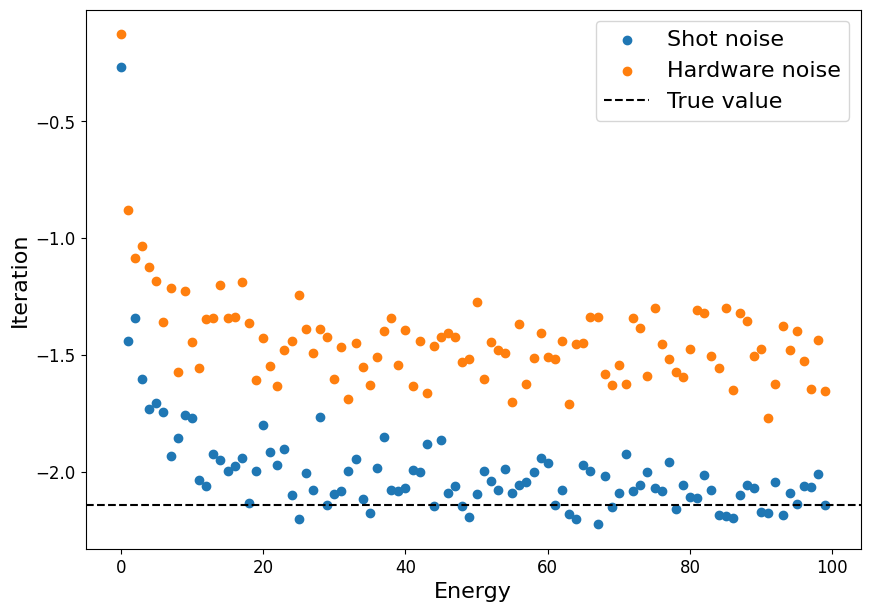

In [12]:
plt.figure(figsize=(10, 7))
plt.scatter(range(100), normal_energies, label="Shot noise")
plt.scatter(range(100), noisy_energies, label="Hardware noise")
plt.axhline(y=-2.143, linestyle="--", label="True value", color="black")
plt.ylabel("Iteration", fontsize=16)
plt.yticks(fontsize=12)
plt.xlabel("Energy", fontsize=16)
plt.xticks(fontsize=12)
plt.legend(fontsize=16)